<a href="https://colab.research.google.com/github/Willgnner-Santos/legal-LLM-input-representation-PTBR/blob/main/ML/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn matplotlib seaborn tqdm

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Melhores parâmetros encontrados: {'weights': 'distance', 'n_neighbors': 11, 'metric': 'cosine'}
Acurácia: 0.8815028901734104
Precisão (macro): 0.9052625261842469
Recall (macro): 0.8403199799733246
F1-score (macro): 0.8574251656112105
MCC: 0.870685242348955

Relatório completo:

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        88
           1       1.00      0.50      0.67         2
           2       0.82      0.85      0.83        59
           3       1.00      1.00      1.00         3
           4       1.00      0.67      0.80         3
           5       0.94      0.97      0.95        30
           6       0.83      1.00      0.91         5
           7       0.92      0.72      0.81        61
           8       0.89      1.00      0.94        17
           9       0.86      0.98      0.92       100
          10       1.00      0.67      0.80         6
          1

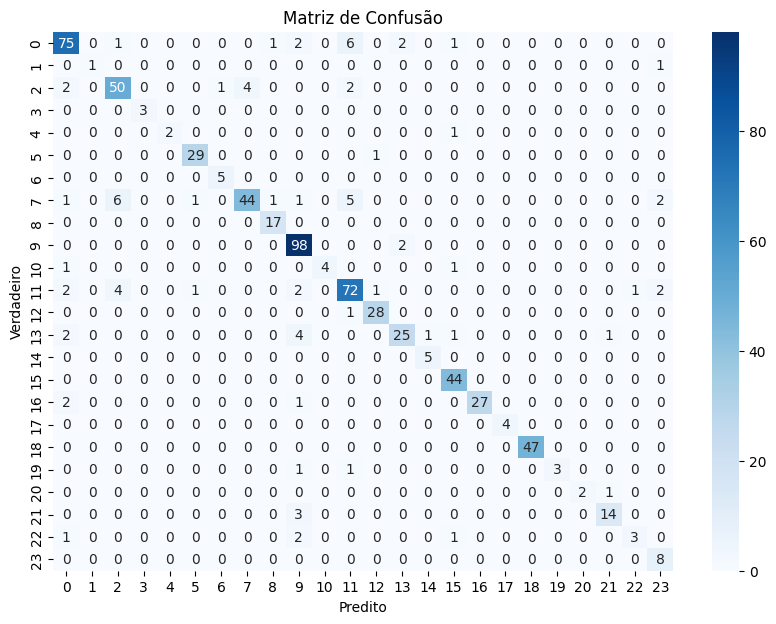

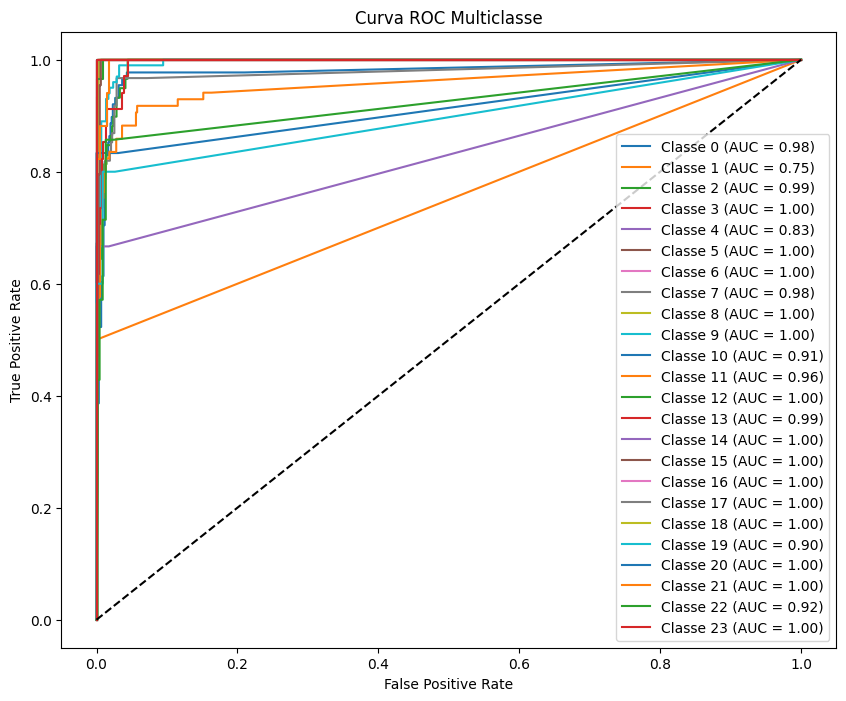

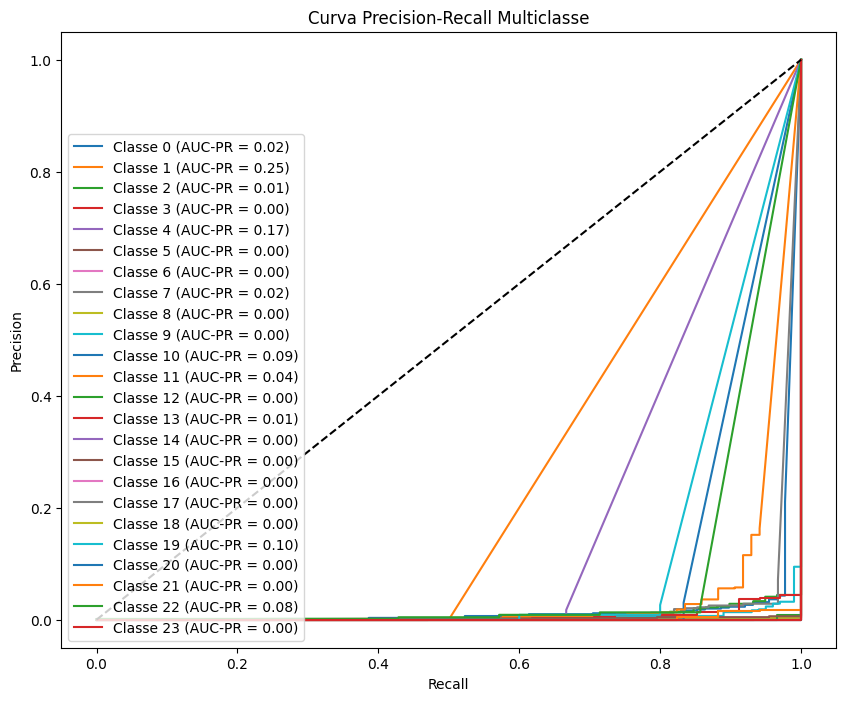

Arquivos salvos com sucesso em: /content/drive/MyDrive/Colab Notebooks/Defesa final/ML/KNN /Métricas-de-Avaliação


In [ ]:
# Imports
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, auc, matthews_corrcoef, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar dados
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Defesa final/ML/KNN /Dados/dataset-petitions-legal-br.csv')

X = df['facts']
le = LabelEncoder()
y = le.fit_transform(df['issue_area_label'])

# Vetorização TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_vectorized = vectorizer.fit_transform(X)

# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y, test_size=0.2, random_state=42, stratify=y
)

# Definir modelo KNN
param_dist = {
    'n_neighbors': list(range(3, 20)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

knn = KNeighborsClassifier()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    knn,
    param_distributions=param_dist,
    n_iter=15,
    scoring='accuracy',
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Melhores parâmetros encontrados:", random_search.best_params_)

best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

# Previsões
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Métricas principais
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precisão (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))
print("MCC:", matthews_corrcoef(y_test, y_pred))

print("\nRelatório completo:\n")
print(classification_report(y_test, y_pred))

# Validação cruzada
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cv_results = cross_validate(
    best_model, X_vectorized, y, cv=5, scoring=scoring, return_train_score=False
)

print("\n==== Validação Cruzada ====")
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric}: {scores.mean():.4f} ± {scores.std():.4f}")

# Matriz de confusão
plt.figure(figsize=(10,7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# AUC-ROC e AUC-PR Multiclasse
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# ROC
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC Multiclasse')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# AUC-PR
precision = dict()
recall = dict()
pr_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision[i], recall[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    pr_auc[i] = auc(recall[i], precision[i])
    plt.plot(recall[i], precision[i], label=f'Classe {i} (AUC-PR = {pr_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva Precision-Recall Multiclasse')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

# Registro das métricas
metrics = {
    'CV_Accuracy_Mean': [cv_results['test_accuracy'].mean()],
    'CV_Accuracy_Std': [cv_results['test_accuracy'].std()],
    'Accuracy': [accuracy_score(y_test, y_pred)],
    'Precision_macro': [precision_score(y_test, y_pred, average='macro')],
    'Recall_macro': [recall_score(y_test, y_pred, average='macro')],
    'F1_macro': [f1_score(y_test, y_pred, average='macro')],
    'MCC': [matthews_corrcoef(y_test, y_pred)],
    'AUC_ROC_Mean': [np.mean(list(roc_auc.values()))],
    'AUC_PR_Mean': [np.mean(list(pr_auc.values()))],
    'Best_Params': [random_search.best_params_]
}

df_metrics = pd.DataFrame(metrics)

report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

output_dir = '/content/drive/MyDrive/Colab Notebooks/Defesa final/ML/KNN /Métricas-de-Avaliação'
os.makedirs(output_dir, exist_ok=True)

df_metrics.to_csv(f'{output_dir}/metrics_summary_KNN.csv', index=False)
df_report.to_csv(f'{output_dir}/classification_report_KNN.csv', index=True)

print("Arquivos salvos com sucesso em:", output_dir)

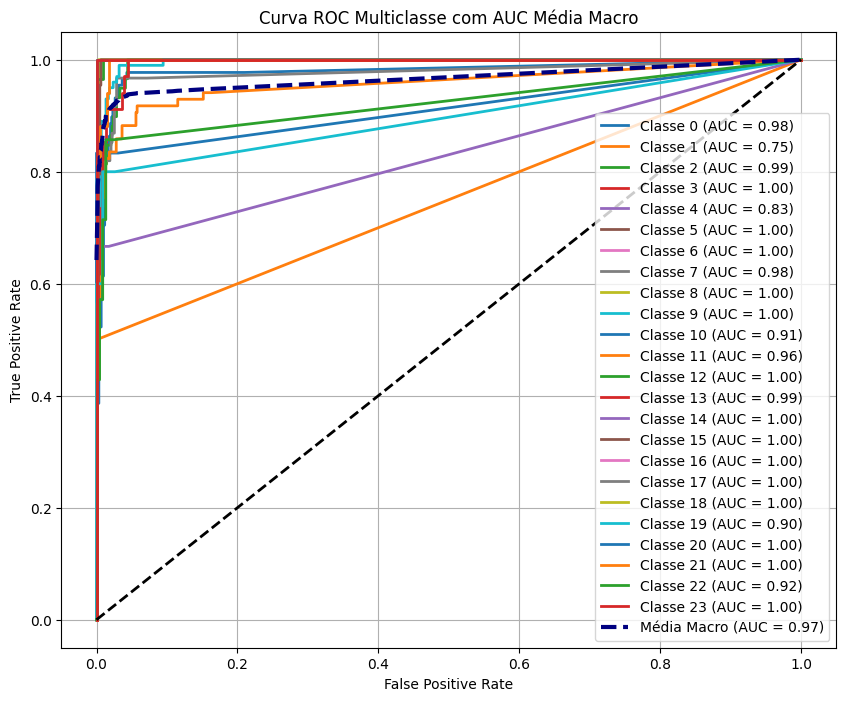

AUC-ROC Média Macro: 0.9668
Matthews Correlation Coefficient (MCC): 0.8707


In [ ]:
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Preparar dados binarizados para ROC multiclasse
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# Calcular ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

# Calcular média macro da AUC-ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

auc_roc_macro = auc(all_fpr, mean_tpr)

# Plotar curva média
plt.plot(all_fpr, mean_tpr, color='navy', linestyle='--',
         label=f'Média Macro (AUC = {auc_roc_macro:.2f})', lw=3)

# Plotar linha de chance
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.title('Curva ROC Multiclasse com AUC Média Macro')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# MCC
mcc = matthews_corrcoef(y_test, y_pred)

# Exibir resultados
print(f'AUC-ROC Média Macro: {auc_roc_macro:.4f}')
print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')

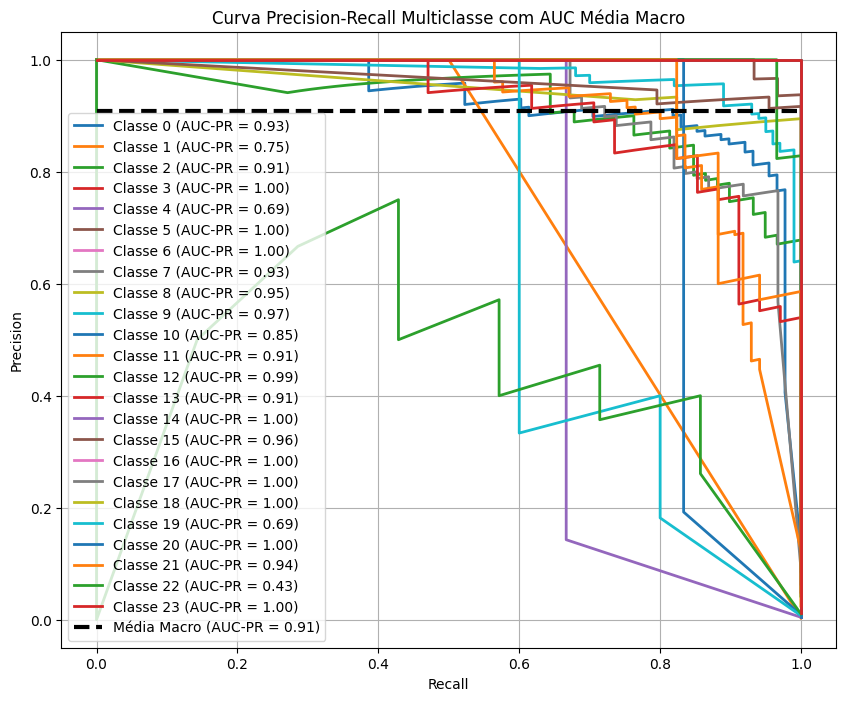

AUC-PR Média Macro: 0.9090


In [ ]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# AUC-PR para cada classe
precision = dict()
recall = dict()
pr_auc = dict()

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    pr_auc[i] = auc(recall[i], precision[i])
    plt.plot(recall[i], precision[i],
             lw=2, label=f'Classe {i} (AUC-PR = {pr_auc[i]:.2f})')

# Calcular média macro da AUC-PR
auc_pr_macro = np.mean(list(pr_auc.values()))

# Plot da média como linha tracejada (não é uma média de curva, apenas do AUC)
plt.plot([0, 1], [auc_pr_macro, auc_pr_macro], 'k--',
         label=f'Média Macro (AUC-PR = {auc_pr_macro:.2f})', lw=3)

plt.title('Curva Precision-Recall Multiclasse com AUC Média Macro')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Exibir resultados
print(f'AUC-PR Média Macro: {auc_pr_macro:.4f}')